# Monophonic vs Polyphonic Synthesis — Notebook Overview

This notebook demonstrates two approaches to synthesizing sound and inspecting their spectra:

- Part 1: Monophonic synthesis — generate single sine tones sequentially, apply a simple ADSR envelope, and visualize waveform, FFT and spectrogram.
- Part 2: Polyphonic synthesis from MIDI — programmatically create a tiny MIDI file, parse it to timed events, synthesize overlapping notes with additive sine waves, and compare the resulting waveform/spectrogram with the monophonic example.

Run the cells in order to reproduce the WAV files and plots located in `outputs/`.

In [48]:
%pip install --quiet mido numpy scipy matplotlib soundfile
# NOTE: the above command installs the packages used in this notebook.
# If you already have them in your environment you can skip rerunning this cell.

Note: you may need to restart the kernel to use updated packages.


In [49]:
# Standard imports used throughout the notebook
import numpy as np
import matplotlib.pyplot as plt
# `spectrogram` is used for the multi-FFT time-frequency view
from scipy.signal import spectrogram
# `soundfile` is used to write WAV files (optional but convenient)
import soundfile as sf
# `mido` is used to construct and parse simple MIDI files for the polyphonic example
import mido
import os

# Make plots wider by default for readability
plt.rcParams['figure.figsize'] = (10, 4)

## Utility Functions

This notebook uses four main utility functions to convert notes to frequencies and visualize audio signals in different ways. Here's what each does:

### `midi_note_to_freq(m)` — Convert MIDI notes to frequency
**Purpose:** Translates MIDI note numbers (0–127, where 69 = A4) into their corresponding frequency in Hertz (Hz).

**How it works:**
- Uses **equal-tempered tuning**, the standard system in Western music
- Formula: `440 * 2^((m - 69) / 12)` scales the reference frequency (A4 = 440 Hz) by semitone intervals
- Each semitone multiplies frequency by `2^(1/12) ≈ 1.0595`

**Example:** MIDI 60 (middle C) → ~261.63 Hz, MIDI 72 (C one octave higher) → ~523.25 Hz

---

### `plot_waveform(signal, sr, title, tmin, tmax)` — Visualize amplitude over time
**Purpose:** Displays the **waveform** of an audio signal (amplitude vs. time).

**What you see:**
- Vertical axis: amplitude (pressure/voltage) of the sound wave
- Horizontal axis: time in seconds
- Optional `tmin`/`tmax` parameters zoom into a specific time window (e.g., first 0.1 seconds)

**Why it matters:**
- Shows the **raw signal shape** and can reveal artifacts like clicks or discontinuities
- For sine waves, you'll see a smooth oscillating pattern; for polyphony, overlapping notes appear as interference patterns

---

### `plot_single_fft(signal, sr, title, n_fft, freq_limit)` — Show frequency content (global)
**Purpose:** Computes one Fast Fourier Transform (FFT) over the **entire signal** to reveal which frequencies are present and how strong they are.

**What you see:**
- Vertical axis: magnitude in dB (power, scaled logarithmically)
- Horizontal axis: frequency in Hz
- Sharp peaks indicate dominant frequencies (e.g., the note's fundamental and harmonics)

**Why it matters:**
- For a monophonic melody, you'll see distinct peaks for each played note
- For polyphony, multiple peaks appear simultaneously (showing chords)
- Helps identify pitch, harmonics, and noise

---

### `plot_spectrogram(signal, sr, title, nperseg, noverlap, freq_limit)` — Show frequency content over time
**Purpose:** Computes **many short-time FFTs** to show how frequencies evolve as the signal plays (time–frequency representation).

**What you see:**
- Horizontal axis: time in seconds
- Vertical axis: frequency in Hz
- Color brightness: intensity (louder = brighter)
- "Ridges" (bright traces) show which frequencies are active at each moment

**Why it matters:**
- Unlike a single FFT, you can see when notes **start and stop**
- For monophonic signals, you'll see a single ridge jumping between note frequencies
- For polyphony, multiple overlapping ridges show notes sounding together
- Essential for understanding **polyphonic structure** visually

---

### `adsr_envelope(length, sr, attack, release)` — Shape note amplitude over time
**Purpose:** Applies an **envelope** to a note, controlling how its volume evolves from start to finish.

**The problem it solves:**
- A raw sine wave has constant amplitude from the very beginning and very end
- This creates sharp **clicks** at note boundaries (sudden jumps in amplitude)
- Real instruments "swell in" (attack) and "fade out" (release)

**How it works:**
- **Attack phase**: Volume ramps from 0 to 1 over `attack` seconds (e.g., 0.01 s = 10 ms)
- **Sustain phase**: Volume stays at 1 for the middle of the note
- **Release phase**: Volume ramps from 1 to 0 over `release` seconds (e.g., 0.05 s = 50 ms)

**Why it matters:**
- Eliminates clicks and pops at note transitions
- Makes synthetic audio sound more like real instruments (which never change amplitude instantaneously)
- The attack/release times directly affect the "feel" of the sound:
  - **Short attack** (10 ms): percussive, snappy (like a piano or bell)
  - **Long attack** (100+ ms): smooth, padded (like a violin bow or pad synthesizer)
  - **Short release** (50 ms): sharp cutoff, dry sound
  - **Long release** (500+ ms): tail-off, reverberant feeling


In [50]:
# Utilities: conversions and plotting helpers

def midi_note_to_freq(m):
    # MIDI note to frequency (A4 = MIDI 69 = 440 Hz) using equal-tempered tuning.
    return 440.0 * 2 ** ((m - 69) / 12.0)

def plot_waveform(signal, sr, title='Waveform', tmin=None, tmax=None):
    # Plot amplitude vs time; optionally focus on a time window with tmin/tmax.
    times = np.arange(len(signal)) / sr
    if tmin is not None and tmax is not None:
        mask = (times >= tmin) & (times <= tmax)
        times = times[mask]
        sig = signal[mask]
    else:
        sig = signal
    plt.figure()
    plt.plot(times, sig, linewidth=0.7)
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_single_fft(signal, sr, title='Single FFT (magnitude)', n_fft=None, freq_limit=5000):
    # Compute a single (global) FFT to show the overall frequency content of `signal`.
    # We apply a Hann window to reduce leakage before taking the FFT.
    x = signal.astype(float)
    if n_fft is None:
        n_fft = len(x)
    X = np.fft.rfft(x * np.hanning(len(x)), n=n_fft)
    freqs = np.fft.rfftfreq(n_fft, 1.0 / sr)
    mag = np.abs(X)
    # For clarity limit the frequency axis to `freq_limit` Hz (fundamentals/harmonics)
    idx = freqs <= freq_limit
    plt.figure()
    plt.plot(freqs[idx], 20 * np.log10(mag[idx] + 1e-12))
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(signal, sr, title='Spectrogram', nperseg=1024, noverlap=None, freq_limit=8000):
    # Spectrogram: many short-time FFTs to show frequency content over time.
    if noverlap is None:
        noverlap = nperseg // 2
    f, t, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, noverlap=noverlap, scaling='spectrum')
    # Restrict frequency axis to focus on fundamentals and low harmonics
    fmask = f <= freq_limit
    plt.figure()
    plt.pcolormesh(t, f[fmask], 10 * np.log10(Sxx[fmask, :] + 1e-12), shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title(title)
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()
    plt.show()

def adsr_envelope(length, sr, attack=0.01, release=0.05):
    # ADSR-like envelope: linear attack, sustain, linear release.
    # Parameters: `length` in seconds, `sr` sample rate, `attack`/`release` in seconds.
    # NEW: attack and release are clamped so they don't exceed the total note length.
    
    n = int(length * sr)
    env = np.ones(n)
    
    # Clamp attack and release to not exceed total length
    a = int(attack * sr)
    r = int(release * sr)
    
    # Apply attack ramp (0 → 1)
    if a > 0:
        env[:a] = np.linspace(0, 1, a)
    
    # Apply release ramp (1 → 0)
    if r > 0:
        env[-r:] = np.linspace(1, 0, r)
    
    return env

## Part 1 — Monophonic synthesis
This section synthesizes a short melody using single sine tones played sequentially (monophonic).
We will show:
- The waveform (time-domain),
- A single global FFT (one FFT over the whole signal) to show frequency content,
- A spectrogram (many FFTs over short windows) to show how frequencies evolve in time.

In [51]:
# Monophonic sequence: list of (midi_note, duration_seconds)
# We use MIDI note numbers only for convenience; they are converted to Hz when synthesizing.
# At this stage, we won't use MIDI files

sr = 22050  # sample rate (Hz)
mono_notes = [(64, 0.5), (66, 0.5), (68, 0.5), (69, 1.0), (68, 0.5), (66, 0.5), (64, 1.0)] # Monophonic sequence

def synth_mono_sequence(notes, sr=22050):
    # Synthesize each note as a sine wave, apply a short ADSR envelope and concatenate.
    parts = []
    for note, dur in notes: # Iterate over monophonic sequence
        freq = midi_note_to_freq(note) # Converting MIDI note to Hz
        t = np.linspace(0, dur, int(sr * dur), endpoint=False) # Generates sampled time values of note duration at sample rate sr
        
        # Pure sine tone (monophonic), amplitude chosen to avoid clipping when saved
        # Clipping occurs when signal's amplitude exceeds the max value that can be represented
        tone = 0.6 * np.sin(2 * np.pi * freq * t) 
        env = adsr_envelope(dur, sr) # Apply a small attack and release to avoid clicks
        parts.append(tone * env)

    return np.concatenate(parts) 

In [52]:
# Generate the monophonic signal and save it to `outputs/mono_synthesis.wav`
mono_signal = synth_mono_sequence(mono_notes, sr=sr)
os.makedirs('outputs', exist_ok=True)
sf_path_mono = 'outputs/mono_synthesis.wav'
sf.write(sf_path_mono, mono_signal, sr)

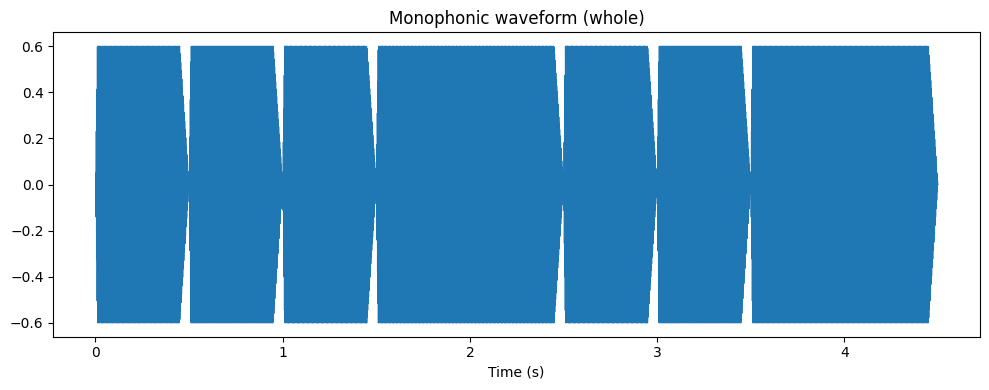

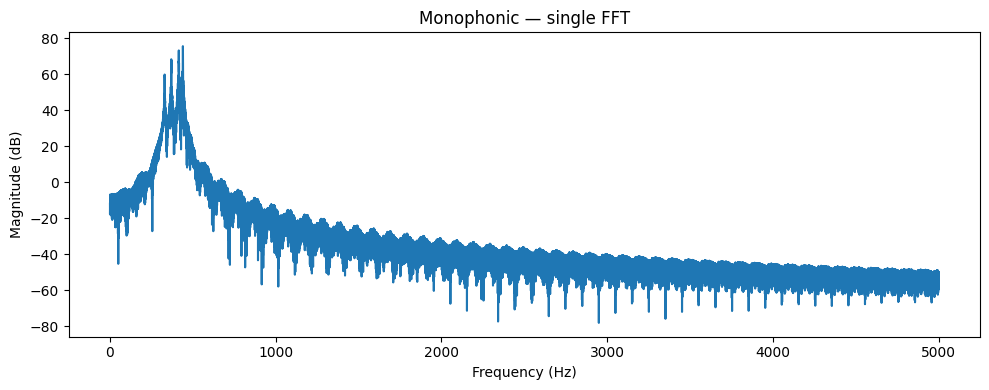

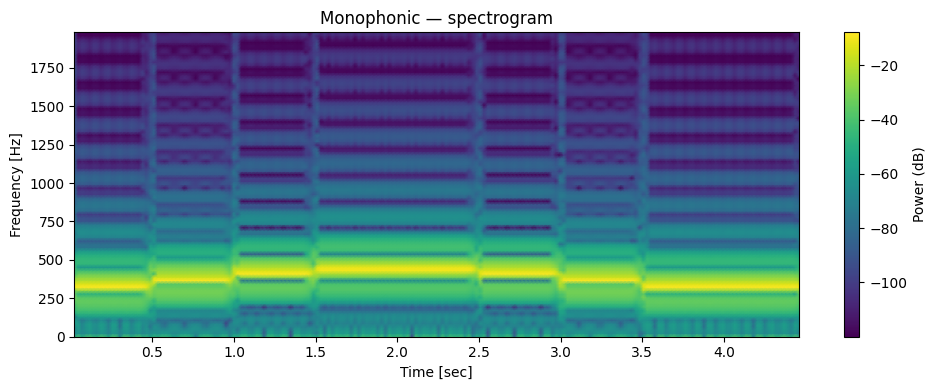

In [53]:
# Visualizations: waveform, single FFT and spectrogram
plot_waveform(mono_signal, sr, title='Monophonic waveform (whole)')
plot_single_fft(mono_signal, sr, title='Monophonic — single FFT')
plot_spectrogram(mono_signal, sr, title='Monophonic — spectrogram', nperseg=1024, freq_limit=2000)

## Part 2 — Polyphonic via MIDI (programmatic)
We will **create a tiny MIDI file** with **overlapping notes** and then synthesize audio by additive synthesis.

**Additive synthesis creates sound by summing many individual sinusoidal components (partials), each with its own frequency, amplitude, and phase.**

The simple MIDI file has a **single track** and **fixed tempo**:

- Single track: all events (notes, instruments, tempo changes…) are stored in a single timeline of events (track)
- Fixed tempo: the speed of the music (tempo) is constant.

Each event has:

- Delta-time: ticks since the last event
- MIDI message: instruction describing what should happen in the musical perfomance (note_on, note_off, etc)

**The MIDI is only used for note timing and velocities; the audio is synthesized here with sine waves
so the example is self-contained (no external soundfont required).**

The following cells demonstrate how to encode start/end times for overlapping notes (polyphony):

In [54]:
mid = mido.MidiFile() # Creates an empty MIDI (no tracks, events, tempo...)
track = mido.MidiTrack() # Creates a single track where messages will go (not yet part of MIDI file)
mid.tracks.append(track) # Include the track in the MIDI file

# Polyphony is handled inside the same track via overlapping note_on/note_off messages

# MIDI tempo must be in MICROSECONDS PER BEAT, not BPM
# Tempo: 120 BPM → 500000 MPB (This basically means that a beat is 0,5 seconds long)
tempo = mido.bpm2tempo(120) # Converts BPM to MICROSECONDS PER BEAT
track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0)) # add initial meta-event setting tempo
ticks_per_beat = mid.ticks_per_beat # specifies how many MIDI ticks correspond to a beat 

# Helper: convert seconds to MIDI ticks using the current tempo and ticks_per_beat
# To place a note exactly at 0.5 seconds, 2 seconds, etc., you must convert seconds → ticks.
def seconds_to_ticks(seconds, tempo, ticks_per_beat):
    # tempo is MICROSECONDS PER BEAT; 
    # convert first: MICROSECONDS PER BEAT → SECONDS PER BEAT
    us_per_beat = tempo 
    seconds_per_beat = us_per_beat / 1e6 
    beats = seconds / seconds_per_beat # number of beats that fit in given seconds
    return int(round(beats * ticks_per_beat)) # returns ticks corresponding to given seconds

In [55]:
# Define a short progression with intentionally overlapping notes
events = [  # (note, start_s, duration_s, velocity)
    (60, 0.0, 1.0, 100),
    (64, 0.25, 1.0, 100),
    (67, 0.5, 1.0, 100),
    (72, 1.0, 1.5, 100),
    (76, 1.25, 1.0, 100),
    (79, 1.5, 1.0, 100)
]

# Convert these events to note_on/note_off messages with absolute tick times
msgs = []
for note, start, dur, vel in events: # Iterate over each note event
    t_on = seconds_to_ticks(start, tempo, ticks_per_beat) # Convert start time to ticks
    t_off = seconds_to_ticks(start + dur, tempo, ticks_per_beat) # Convert end time to ticks
    msgs.append((t_on, mido.Message('note_on', note=note, velocity=vel, time=0))) # Note on at t_on
    msgs.append((t_off, mido.Message('note_off', note=note, velocity=0, time=0))) # Note off at t_off

# Sorting by absolute tick time to prepare for delta-time conversion:
msgs.sort(key=lambda x: x[0]) # Sort-by first element of tuple (absolute tick time)

# Display messages for verification:
print("Sorted messages (absolute tick times):")  
for t, msg in msgs:
    print(f"Tick {t}: {msg}")

Sorted messages (absolute tick times):
Tick 0: note_on channel=0 note=60 velocity=100 time=0
Tick 240: note_on channel=0 note=64 velocity=100 time=0
Tick 480: note_on channel=0 note=67 velocity=100 time=0
Tick 960: note_off channel=0 note=60 velocity=0 time=0
Tick 960: note_on channel=0 note=72 velocity=100 time=0
Tick 1200: note_off channel=0 note=64 velocity=0 time=0
Tick 1200: note_on channel=0 note=76 velocity=100 time=0
Tick 1440: note_off channel=0 note=67 velocity=0 time=0
Tick 1440: note_on channel=0 note=79 velocity=100 time=0
Tick 2160: note_off channel=0 note=76 velocity=0 time=0
Tick 2400: note_off channel=0 note=72 velocity=0 time=0
Tick 2400: note_off channel=0 note=79 velocity=0 time=0


NOTE:

- We compute each message as an (absolute_tick, message) pair (and set `message.time = 0`) because absolute ticks make it easy to compute start/end positions, detect overlaps, and sort events on a global timeline.
- Before saving the MIDI file we convert absolute ticks to MIDI **delta** times (per-message ticks) by subtracting the previous absolute tick: `delta = abs_tick - last_abs_tick` and then set `message.time = delta`.

In short: absolute ticks are easier for synthesis and buffer sizing; delta times are the compact, streamable format MIDI files require.

In [56]:
# Convert to absolute tick times to delta-times and append to the track
last_tick = 0
for tick, message in msgs:
    delta = tick - last_tick
    message.time = delta
    track.append(message)
    last_tick = tick

print('MIDI messages in track:')
for msg in track:
    print(msg)

midi_path = 'outputs/example_polyphony.mid'
mid.save(midi_path)
print('Saved MIDI to', midi_path)

MIDI messages in track:
MetaMessage('set_tempo', tempo=500000, time=0)
note_on channel=0 note=60 velocity=100 time=0
note_on channel=0 note=64 velocity=100 time=240
note_on channel=0 note=67 velocity=100 time=240
note_off channel=0 note=60 velocity=0 time=480
note_on channel=0 note=72 velocity=100 time=0
note_off channel=0 note=64 velocity=0 time=240
note_on channel=0 note=76 velocity=100 time=0
note_off channel=0 note=67 velocity=0 time=240
note_on channel=0 note=79 velocity=100 time=0
note_off channel=0 note=76 velocity=0 time=720
note_off channel=0 note=72 velocity=0 time=240
note_off channel=0 note=79 velocity=0 time=0
Saved MIDI to outputs/example_polyphony.mid


In [57]:
# Parse the MIDI file and extract note events as (start_s, end_s, note, vel)
def parse_midi_to_events(midi_path):
    # We assume a single track and a (nearly) constant tempo set earlier in the file.
    mf = mido.MidiFile(midi_path)
    ticks_per_beat = mf.ticks_per_beat

    # Extract tempo from the first message (assumed to be set_tempo)
    tempo = mf.tracks[0][0].tempo if mf.tracks[0][0].type == 'set_tempo' else 500000 # If there's no set_tempo message, uses default 500000

    # Walk messages accumulating absolute tick times and collect matched note on/off pairs
    abs_ticks = 0
    note_states = {}  # note -> (start_tick, velocity)
    events = []
    for msg in mf.tracks[0]:  # iterates through messages in time order with msg.time in ticks
        abs_ticks += msg.time
        if msg.type == 'note_on' and msg.velocity > 0:
            note_states[msg.note] = (abs_ticks, msg.velocity)
        elif (msg.type == 'note_off') or (msg.type == 'note_on' and msg.velocity == 0):
            if msg.note in note_states:
                start_tick, vel = note_states.pop(msg.note)
                events.append((start_tick, abs_ticks, msg.note, vel))
    # Convert ticks to seconds using the tempo in effect (simple approach assuming constant tempo):
    def ticks_to_seconds(ticks, tempo, ticks_per_beat):
        return (ticks * tempo) / (ticks_per_beat * 1e6)
    events_sec = [(ticks_to_seconds(s, tempo, ticks_per_beat), ticks_to_seconds(e, tempo, ticks_per_beat), n, v) for (s, e, n, v) in events]
    return events_sec

events_sec = parse_midi_to_events(midi_path)
print('Parsed events (start_s, end_s, note, vel):')
for ev in events_sec:
    print(ev)

Parsed events (start_s, end_s, note, vel):
(0.0, 1.0, 60, 100)
(0.25, 1.25, 64, 100)
(0.5, 1.5, 67, 100)
(1.25, 2.25, 76, 100)
(1.0, 2.5, 72, 100)
(1.5, 2.5, 79, 100)


Saved synthesized polyphonic WAV to outputs/poly_from_midi.wav


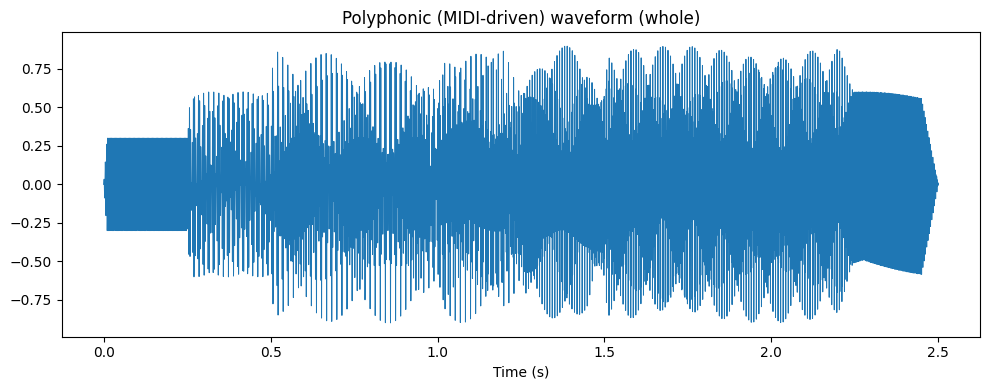

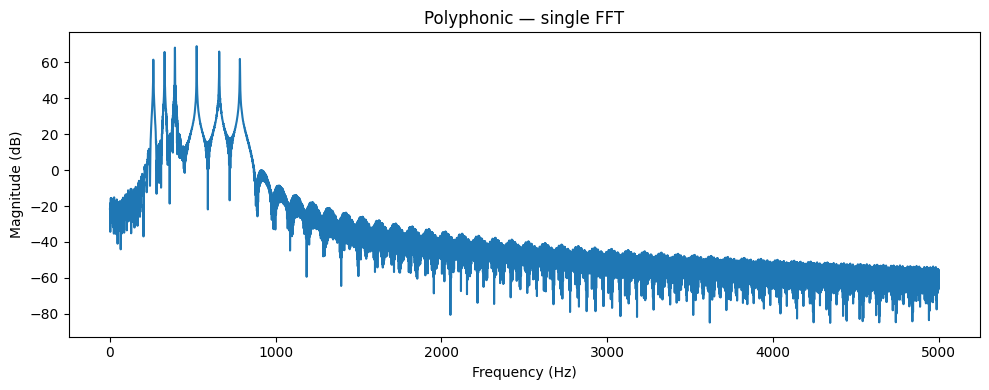

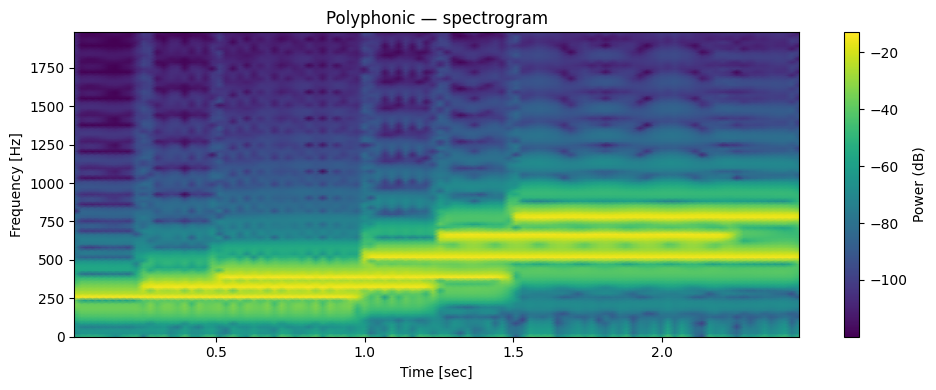

In [ ]:
def synth_from_midi_events(events, sr=22050, max_duration=None):
    # Simple polyphonic synthesizer using linspace-based time vectors.
    # Input: events is a list of tuples (start_s, end_s, note, vel).

    if not events:
        return np.zeros(0, dtype=float)

    # Determine buffer length in samples (use max event end time)
    max_end_s = max(e for s, e, n, v in events)
    if max_duration is None:
        n_samples = int(np.ceil(max_end_s * sr))
    else:
        n_samples = max(int(np.ceil(max_end_s * sr)), int(np.ceil(max_duration * sr)))

    out = np.zeros(n_samples, dtype=float)

    # Synthesize each event and add it into the output buffer
    for start_s, end_s, note, vel in events:
        start_i = int(np.floor(start_s * sr + 1e-9))
        length = int(np.round((end_s - start_s) * sr))
        if length <= 0:
            continue

        # Time vector for this note (seconds)
        t = np.linspace(0, length / sr, length, endpoint=False)
        freq = midi_note_to_freq(note)
        amp = (vel / 127.0) * 0.4
        tone = amp * np.sin(2 * np.pi * freq * t)

        # Envelope (expects seconds) — clamp/adjust if lengths mismatch
        env = adsr_envelope(length / sr, sr)
        if len(env) != len(tone):
            if len(env) > len(tone):
                env = env[: len(tone)]
            else:
                env = np.concatenate([env, np.ones(len(tone) - len(env))])
        tone = tone * env

        # Mix into output buffer, clipping at buffer boundaries if necessary
        end_i = start_i + len(tone)
        if start_i < 0:
            # skip negative starts (shouldn't happen with valid events)
            continue
        if end_i > n_samples:
            out[start_i:] += tone[: n_samples - start_i]
        else:
            out[start_i:end_i] += tone

    # Normalize to avoid clipping when saving to WAV
    maxv = np.max(np.abs(out))
    if maxv > 0:
        out = out / (maxv + 1e-12) * 0.9
    return out


# Synthesize and save the polyphonic output (this call remains at the notebook level)
poly_signal = synth_from_midi_events(events_sec, sr=sr)
os.makedirs('outputs', exist_ok=True)
sf_path_poly = 'outputs/poly_from_midi.wav'
sf.write(sf_path_poly, poly_signal, sr)
print('Saved synthesized polyphonic WAV to', sf_path_poly)

# Plots for polyphonic output: waveform, single FFT, and spectrogram
plot_waveform(poly_signal, sr, title='Polyphonic (MIDI-driven) waveform (whole)')
plot_single_fft(poly_signal, sr, title='Polyphonic — single FFT', freq_limit=5000)
plot_spectrogram(poly_signal, sr, title='Polyphonic — spectrogram', nperseg=1024, freq_limit=2000)

## Comparison notes (visual)
- The single FFT gives a snapshot of frequency content (global or selected window). For monophonic sound the FFT will show strong peaks at the played note frequencies. For polyphony the FFT will show multiple simultaneous peaks (chords).
- The spectrogram shows how frequencies change over time. In the monophonic spectrogram you'll see a single ridge moving from note to note. In the polyphonic spectrogram you'll see multiple ridges overlapping when notes sound together.

We intentionally keep the spectral analysis simple (one global FFT and a standard spectrogram) to emphasize the evolving frequency content rather than low-level spectral details.